In [1]:
#Libraries all set up
import numpy as np
import matplotlib.pyplot as plt
import h5py
from cartopy import crs as ccrs
import matplotlib.pyplot as plt
from matplotlib import colors
from matplotlib.lines import Line2D
import pandas as pd
from pyhdf.SD import SD, SDC
from pyhdf import HDF, VS, V
from time import gmtime, strftime
from datetime import datetime
import time
import geopy.distance

# Select which cloudsat files should be used by drawing their groundtracks

In [12]:
csfile1path=r"C:\Users\HP\OneDrive\Desktop\HD5 Collection\CLOUDSAT DATA\CLDCLASS-LIDAR\2019001005530_67526_CS_2B-CLDCLASS-LIDAR_GRANULE_P1_R05_E08_F03.hdf"
csfile2path=r"C:\Users\HP\OneDrive\Desktop\HD5 Collection\CLOUDSAT DATA\CLDCLASS-LIDAR\2019001023402_67527_CS_2B-CLDCLASS-LIDAR_GRANULE_P1_R05_E08_F03.hdf"
csfile3path=r"C:\Users\HP\OneDrive\Desktop\HD5 Collection\CLOUDSAT DATA\CLDCLASS-LIDAR\2019001041234_67528_CS_2B-CLDCLASS-LIDAR_GRANULE_P1_R05_E08_F03.hdf"
csfile4path=r"C:\Users\HP\OneDrive\Desktop\HD5 Collection\CLOUDSAT DATA\CLDCLASS-LIDAR\2019001055106_67529_CS_2B-CLDCLASS-LIDAR_GRANULE_P1_R05_E08_F03.hdf"
csfile5path=r"C:\Users\HP\OneDrive\Desktop\HD5 Collection\CLOUDSAT DATA\CLDCLASS-LIDAR\2019001072938_67530_CS_2B-CLDCLASS-LIDAR_GRANULE_P1_R05_E08_F03.hdf"
csfile6path=r"C:\Users\HP\OneDrive\Desktop\HD5 Collection\CLOUDSAT DATA\CLDCLASS-LIDAR\2019001090810_67531_CS_2B-CLDCLASS-LIDAR_GRANULE_P1_R05_E08_F03.hdf"
csfile7path=r"C:\Users\HP\OneDrive\Desktop\HD5 Collection\CLOUDSAT DATA\CLDCLASS-LIDAR\2019001104642_67532_CS_2B-CLDCLASS-LIDAR_GRANULE_P1_R05_E08_F03.hdf"
csfile8path=r"C:\Users\HP\OneDrive\Desktop\HD5 Collection\CLOUDSAT DATA\CLDCLASS-LIDAR\2019001122514_67533_CS_2B-CLDCLASS-LIDAR_GRANULE_P1_R05_E08_F03.hdf"
csfile9path=r"C:\Users\HP\OneDrive\Desktop\HD5 Collection\CLOUDSAT DATA\CLDCLASS-LIDAR\2019001140346_67534_CS_2B-CLDCLASS-LIDAR_GRANULE_P1_R05_E08_F03.hdf"
csfile10path=r"C:\Users\HP\OneDrive\Desktop\HD5 Collection\CLOUDSAT DATA\CLDCLASS-LIDAR\2019001154218_67535_CS_2B-CLDCLASS-LIDAR_GRANULE_P1_R05_E08_F03.hdf"
csfile11path=r"C:\Users\HP\OneDrive\Desktop\HD5 Collection\CLOUDSAT DATA\CLDCLASS-LIDAR\2019001172050_67536_CS_2B-CLDCLASS-LIDAR_GRANULE_P1_R05_E08_F03.hdf"
csfile12path=r"C:\Users\HP\OneDrive\Desktop\HD5 Collection\CLOUDSAT DATA\CLDCLASS-LIDAR\2019001185922_67537_CS_2B-CLDCLASS-LIDAR_GRANULE_P1_R05_E08_F03.hdf"
csfile13path=r"C:\Users\HP\OneDrive\Desktop\HD5 Collection\CLOUDSAT DATA\CLDCLASS-LIDAR\2019001203754_67538_CS_2B-CLDCLASS-LIDAR_GRANULE_P1_R05_E08_F03.hdf"
csfile14path=r"C:\Users\HP\OneDrive\Desktop\HD5 Collection\CLOUDSAT DATA\CLDCLASS-LIDAR\2019001221627_67539_CS_2B-CLDCLASS-LIDAR_GRANULE_P1_R05_E08_F03.hdf"
csfile15path=r"C:\Users\HP\OneDrive\Desktop\HD5 Collection\CLOUDSAT DATA\CLDCLASS-LIDAR\2019001235459_67540_CS_2B-CLDCLASS-LIDAR_GRANULE_P1_R05_E08_F03.hdf"

csatfilepathcol=[csfile1path,csfile2path,csfile3path,csfile4path,csfile5path,csfile6path,csfile7path,csfile8path,csfile9path,csfile10path,csfile11path,csfile12path,csfile13path,csfile14path,csfile15path]

csatfilecol=[]

for i in csatfilepathcol:
    csatfilecol.append(SD(i, SDC.READ))



geofieldcol=[]
def oned_dataset_func(dataset_names,h):
    dataset_list = []
    for i in dataset_names:
        vs = h.vstart()
        xid = vs.find(i)
        dataid = vs.attach(xid)
        dataid.setfields(i)
        nrecs, _, _, _, _ = dataid.inquire()
        data = dataid.read(nRec=nrecs) #Each data point is singleton list, so we need to concatenate them
        data = list(np.concatenate(data)) 
        dataset_list.append(data)
        dataid.detach()
    return dataset_list

for i in csatfilepathcol:
    h=HDF.HDF(i)
    geofieldcol.append(oned_dataset_func(['Latitude','Longitude',"DEM_elevation","Profile_time","Navigation_land_sea_flag","UTC_start","Cloudlayer"],h))
print("geofieldcol is a list of len={}, each element is a list of len={}, corresponding to lat,lon,elevation, profile_time,Land/sea flag,UTC_start time and Cloudlayer file".format(len(geofieldcol),len(geofieldcol[0])))

geofieldcol is a list of len=15, each element is a list of len=7, corresponding to lat,lon,elevation, profile_time,Land/sea flag,UTC_start time and Cloudlayer file


In [84]:
#Testing if the data is being read correctly. Let's see DEM_elevation file for 2nd file, check for 9900th row, expdcted 242
#Latitude is alright,#Longitude is alright,#DEM_elevation is alright,#Profile_time is alright as well
dump=geofieldcol[1][2]
dump[9900]
#Everything is alright

242

In [122]:
#Find the difference between start time between two consecutive files or find the orbital period of the satellite
orbitalperiod=[]
for i in range(len(geofieldcol)):
    orbitalperiod.append(geofieldcol[i][5][0])
for i in range(len(geofieldcol)-1):
    print("Orbit {}={:.3f} sec".format(i+1,np.diff(orbitalperiod)[i]), end =",")
#np.average(np.diff(orbitalperiod)),len(orbitalperiod),len(np.diff(orbitalperiod))

Orbit 1=5912.019 sec,Orbit 2=5911.917 sec,Orbit 3=5912.138 sec,Orbit 4=5912.076 sec,Orbit 5=5912.139 sec,Orbit 6=5912.117 sec,Orbit 7=5911.977 sec,Orbit 8=5912.082 sec,Orbit 9=5911.977 sec,Orbit 10=5912.078 sec,Orbit 11=5912.016 sec,Orbit 12=5912.078 sec,Orbit 13=5912.141 sec,Orbit 14=5912.070 sec,

In [3]:
#Reading the INSAT-3DR data
insatfilepath=r"C:\Users\HP\OneDrive\Desktop\HD5 Collection\L1B data\INSAT-3DR\3RIMG_01JAN2019_0615_L1B_STD_V01R00.h5"
insatfile=h5py.File(r"C:\Users\HP\OneDrive\Desktop\HD5 Collection\L1B data\INSAT-3DR\3RIMG_01JAN2019_0615_L1B_STD_V01R00.h5",'r') #OK, this is file specific, works with other file Download it and retry
insatlat=insatfile["Latitude"]
insatlon=insatfile["Longitude"]
insatlat=np.ma.masked_equal(insatlat,32767)/100
insatlon=np.ma.masked_equal(insatlon,32767)/100
inleftlon=insatfile.attrs['left_longitude'][0]
inrightlon=insatfile.attrs['right_longitude'][0]
intoplat=insatfile.attrs['upper_latitude'][0]
inbottomlat=insatfile.attrs['lower_latitude'][0]



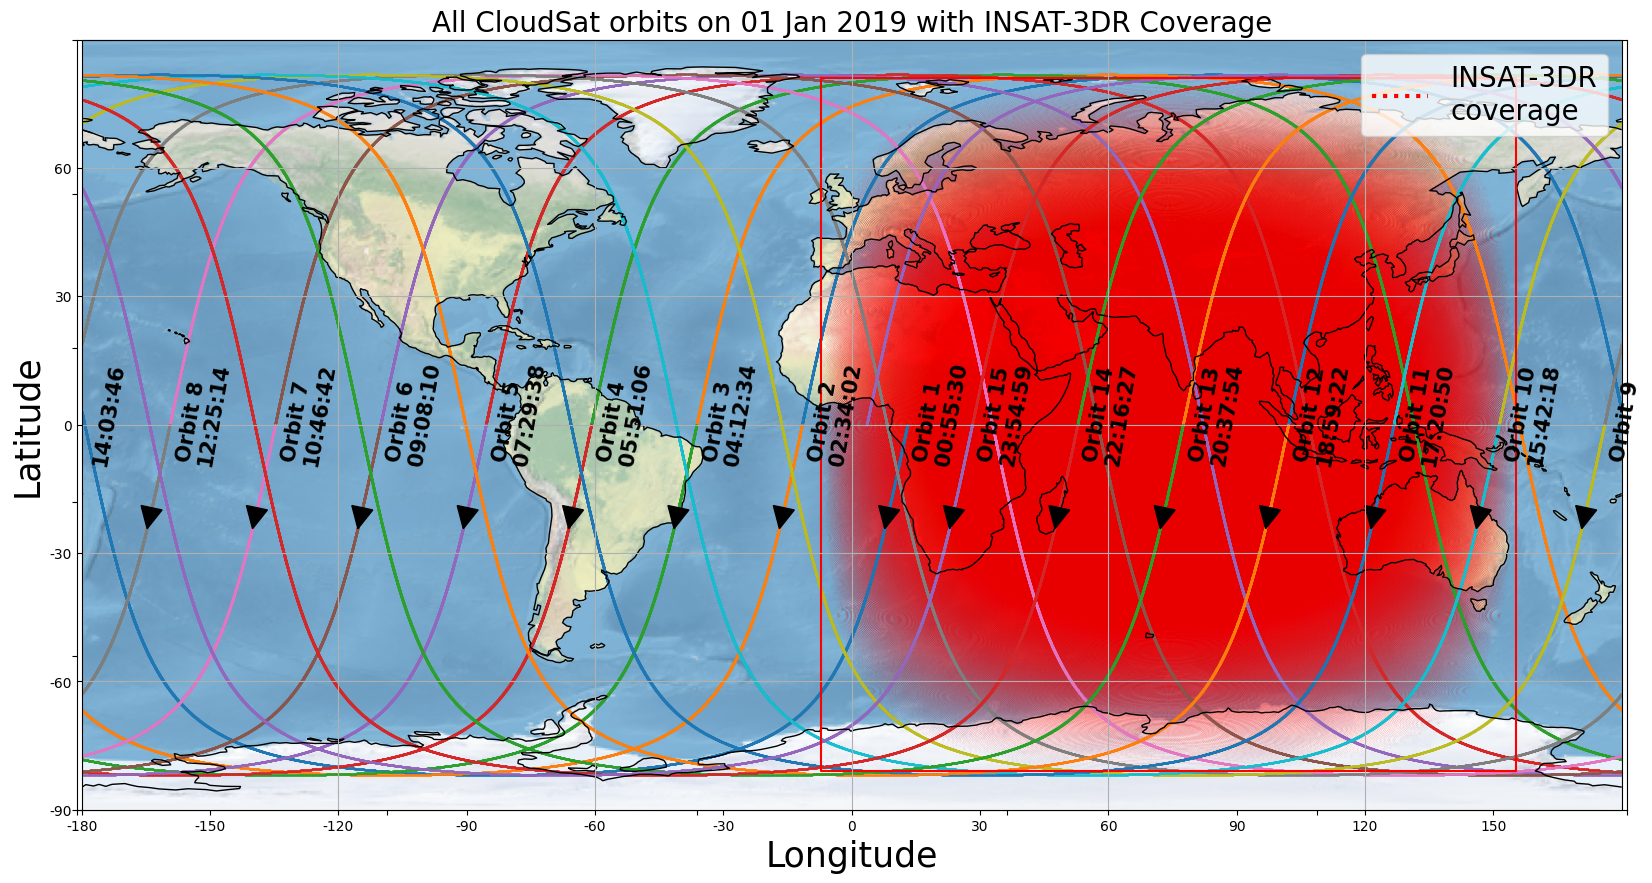

In [4]:
#Plot the lat,lon,elevation, profile_time and UTC_start time for all the files
#['Latitude','Longitude',"DEM_elevation","Profile_time","UTC_start"]

fig=plt.subplots(figsize=(20,10))
#Supress the ticklabels on the x axis
plt.tick_params(labelbottom=False)
plt.tick_params(labelleft=False)

ax=plt.axes(projection=ccrs.PlateCarree())
ax.set_global()
ax.coastlines()
ax.gridlines()
ax.stock_img()
ax.set_xticks(np.arange(-180,180,30), crs=ccrs.PlateCarree())
ax.set_yticks(np.arange(-90,90,30), crs=ccrs.PlateCarree())
ax.set_xticklabels(np.arange(-180,180,30), fontsize=10);
ax.set_yticklabels(np.arange(-90,90,30), fontsize=10);
ax.set_xlabel("Longitude",fontsize=25)
ax.set_ylabel("Latitude",fontsize=25)

ax.plot([inleftlon,inrightlon,inrightlon,inleftlon,inleftlon],[intoplat,intoplat,inbottomlat,inbottomlat,intoplat],color='red',transform=ccrs.PlateCarree()) 
ax.scatter(insatlon,insatlat,s=0.0008,transform=ccrs.PlateCarree(),color="red")

for i in range(len(geofieldcol)):
    ax.scatter(geofieldcol[i][1],geofieldcol[i][0],s=0.1,transform=ccrs.PlateCarree())
    ax.text(geofieldcol[i][1][0]+1.0,geofieldcol[i][0][0]-8,"Orbit "+str(i+1),
    rotation=80,size=15,fontweight="bold",transform=ccrs.PlateCarree())
    ax.arrow(geofieldcol[i][1][2000],geofieldcol[i][0][2000],
    geofieldcol[i][1][2]-geofieldcol[i][1][0],
    geofieldcol[i][0][2]-geofieldcol[i][0][0],
    head_width=5, head_length=5,color="black")
    ax.text(geofieldcol[i][1][0]+6,geofieldcol[i][0][0]-9,time.strftime('%H:%M:%S', time.gmtime(geofieldcol[i][5][0])),
    rotation=80,size=15,fontweight="bold",transform=ccrs.PlateCarree())
#    transform=ccrs.PlateCarree())

ax.legend([Line2D([0], [0], color='red', linewidth=3, linestyle="dotted")],["INSAT-3DR\ncoverage"],loc="upper right",fontsize=20)
ax.set_title("All CloudSat orbits on 01 Jan 2019 with INSAT-3DR Coverage",fontsize=20);
plt.show()


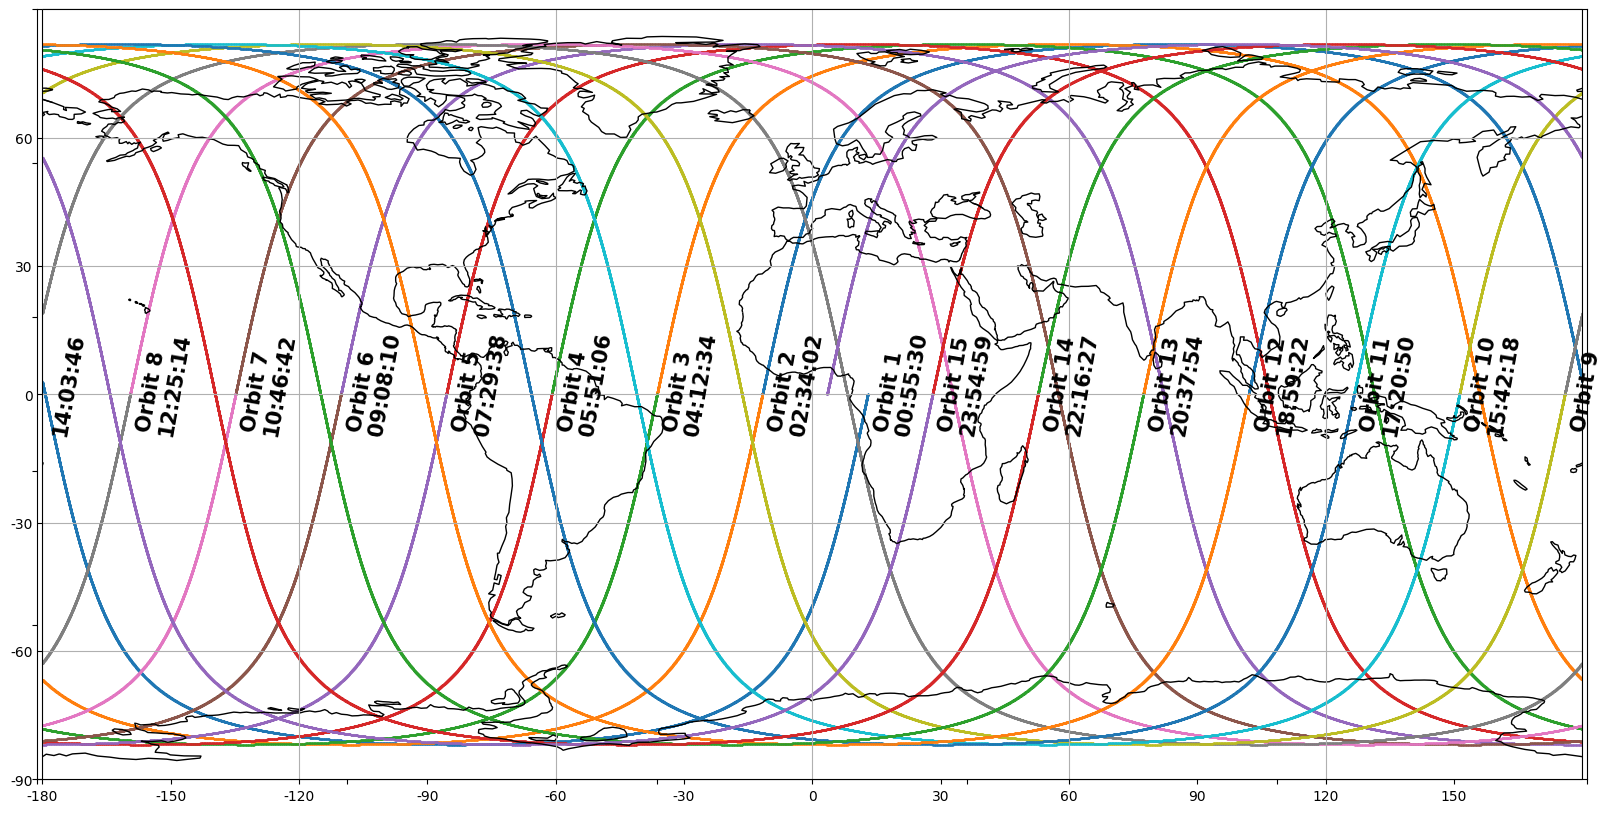

In [28]:
fig=plt.subplots(figsize=(20,10))
#Supress the ticklabels on the x axis
plt.tick_params(labelbottom=False)
plt.tick_params(labelleft=False)

ax=plt.axes(projection=ccrs.PlateCarree())
ax.set_global()
ax.coastlines()
ax.gridlines()
ax.set_xticks(np.arange(-180,180,30), crs=ccrs.PlateCarree())
ax.set_yticks(np.arange(-90,90,30), crs=ccrs.PlateCarree())
ax.set_xticklabels(np.arange(-180,180,30), fontsize=10);
ax.set_yticklabels(np.arange(-90,90,30), fontsize=10);


for i in range(len(geofieldcol)):
    ax.scatter(geofieldcol[i][1],geofieldcol[i][0],s=0.1,transform=ccrs.PlateCarree())
    ax.text(geofieldcol[i][1][0]+1.0,geofieldcol[i][0][0]-8,"Orbit "+str(i+1),
    rotation=80,size=15,fontweight="bold",transform=ccrs.PlateCarree())
    ax.text(geofieldcol[i][1][0]+6,geofieldcol[i][0][0]-9,time.strftime('%H:%M:%S', time.gmtime(geofieldcol[i][4][0])),
    rotation=80,size=15,fontweight="bold",transform=ccrs.PlateCarree())
#    transform=ccrs.PlateCarree())

plt.show()

In [24]:
import time

for i in range(len(geofieldcol)):
    print(time.strftime('%H:%M:%S', time.gmtime(geofieldcol[i][4][0])))

00:55:30
02:34:02
04:12:34
05:51:06
07:29:38
09:08:10
10:46:42
12:25:14
14:03:46
15:42:18
17:20:50
18:59:22
20:37:54
22:16:27
23:54:59


# Collocation with one INSAT-3DR file and one CLOUDSAT file
Chosing INSAT-3DR file from random and CLOUDSAT file with visual inspection, for now

In [13]:
#Reading the INSAT-3DR data
insatfilepath=r"C:\Users\HP\OneDrive\Desktop\HD5 Collection\L1B data\INSAT-3DR\3RIMG_01JAN2019_0615_L1B_STD_V01R00.h5"
insatfile=h5py.File(r"C:\Users\HP\OneDrive\Desktop\HD5 Collection\L1B data\INSAT-3DR\3RIMG_01JAN2019_0615_L1B_STD_V01R00.h5",'r') #OK, this is file specific, works with other file Download it and retry
insatlat=insatfile["Latitude"]
insatlon=insatfile["Longitude"]
insatlat=np.ma.masked_equal(insatlat,32767)/100
insatlon=np.ma.masked_equal(insatlon,32767)/100
inleftlon=insatfile.attrs['left_longitude'][0]
inrightlon=insatfile.attrs['right_longitude'][0]
intoplat=insatfile.attrs['upper_latitude'][0]
inbottomlat=insatfile.attrs['lower_latitude'][0]

csfile4path=r"C:\Users\HP\OneDrive\Desktop\HD5 Collection\CLOUDSAT DATA\CLDCLASS-LIDAR\2019001055106_67529_CS_2B-CLDCLASS-LIDAR_GRANULE_P1_R05_E08_F03.hdf"
csatfilepathcol=[csfile4path]
csatfilecol=[]

for i in csatfilepathcol:
    csatfilecol.append(SD(i, SDC.READ))

geofieldcol=[]
def oned_dataset_func(dataset_names,h):
    dataset_list = []
    for i in dataset_names:
        vs = h.vstart()
        xid = vs.find(i)
        dataid = vs.attach(xid)
        dataid.setfields(i)
        nrecs, _, _, _, _ = dataid.inquire()
        data = dataid.read(nRec=nrecs) #Each data point is singleton list, so we need to concatenate them
        data = list(np.concatenate(data)) 
        dataset_list.append(data)
        dataid.detach()
    return dataset_list

for i in csatfilepathcol:
    h=HDF.HDF(i)
    geofieldcol.append(oned_dataset_func(['Latitude','Longitude',"DEM_elevation","Profile_time","Navigation_land_sea_flag","UTC_start","Cloudlayer"],h))
print("geofieldcol is a list of len={}, each element is a list of len={}, corresponding to lat,lon,elevation, profile_time,Land/sea flag, UTC_start time and Cloudlayer".format(len(geofieldcol),len(geofieldcol[0])))

geofieldcol is a list of len=1, each element is a list of len=7, corresponding to lat,lon,elevation, profile_time,Land/sea flag, UTC_start time and Cloudlayer


Preparing the BT data

In [6]:
#Preparing the BT arrays for INSAT-3DR, just MIR, TIR1, TIR2. Works
channel_list=["IMG_MIR","IMG_TIR1","IMG_TIR2"]
BT_list=[]
for i in channel_list:
    img_arr=insatfile[i][0,:,:]
    img_arr_fill=insatfile[i].attrs['_FillValue'][0]
    #img_arr=np.ma.masked_equal(img_arr,img_arr_fill)
    nanmask=(img_arr==img_arr_fill)
    btlut=np.array(insatfile[i+str('_TEMP')])
    def count2bt(count):
        return btlut[count]
    bt_array=count2bt(img_arr)
    bt_array[nanmask]=np.nan

    BT_list.append(bt_array)
np.nanmin(BT_list[0]),np.nanmax(BT_list[0]),np.nanmin(BT_list[1]),np.nanmax(BT_list[1]),np.nanmin(BT_list[2]),np.nanmax(BT_list[2])

(179.69302, 339.78748, 179.85948, 320.82794, 179.92618, 316.7971)

In [178]:
np.array_equal(np.isnan(BT_list[0]),np.isnan(BT_list[1]))


False

In [53]:
np.isnan(BT_list[2]).sum()

2138002

In [207]:
a=[1,2,3,4,5,6,np.nan,8,9,10]
for i in a:
    if np.isnan(i):
        continue
    print(i)
# for i in a:
#     if np.isnan(i):
#         print("nan")


1
2
3
4
5
6
8
9
10


Preparing the Cloudthickness data and csat time profile

In [14]:
#Preparing time for comparison, preparing the cloudthickness data
csattime=[(i+geofieldcol[0][5][0]) for i in geofieldcol[0][3]] #Works
print(csattime[0:5]);

insat_acq_starttime = str(insatfile.attrs['Acquisition_Start_Time'])[2:13]+"-"+ str(insatfile.attrs['Acquisition_Start_Time'])[14:-1] #To remove a T in the middle of string
insat_acq_endtime = str(insatfile.attrs['Acquisition_End_Time'])[2:13]+"-"+ str(insatfile.attrs['Acquisition_End_Time'])[14:-1]
start_time_obj=datetime.strptime(insat_acq_starttime, "%d-%b-%Y-%H:%M:%S")
end_time_obj=datetime.strptime(insat_acq_endtime, "%d-%b-%Y-%H:%M:%S")
avg_time=start_time_obj+(end_time_obj-start_time_obj)/2
print(avg_time)
insat_sec=avg_time.second+avg_time.minute*60+avg_time.hour*3600
print(insat_sec)

cloudlayerbasecol=[]
cloudlayertopcol=[]
cloudthicknesscol=[]

base=csatfilecol[0].select('CloudLayerBase')[:,:]
#Put nan where base is -99


base[base==-99]=np.nan #Works, cross-checked in panoply for 9703:9706.
#base=np.ma.masked_equal(base,-99)
cloudlayerbasecol.append(base)
top=csatfilecol[0].select('CloudLayerTop')[:,:]
top[top==-99]=np.nan #Alright, cross-checked in panoply
#top=np.ma.masked_equal(top,-99)
cloudlayertopcol.append(top)
thicknessfile=cloudlayertopcol[0]-cloudlayerbasecol[0]
thicknessfile=np.nansum(thicknessfile,axis=1) #nan sum is important, otherwise it'll show nan for all rows. Works cross-checked in panoply, for 9703.
#thickness=np.ma.filled(thickness,np.nan)
cloudthicknesscol.append(thicknessfile)
print(cloudthicknesscol[0][9703:9704]) #Works, cross-checked in panoply

[21066.328125, 21066.48812508583, 21066.648125052452, 21066.808125019073, 21066.968125104904]
2019-01-01 06:28:50
23330
[0.6600001]


# Time collocation (works fine, checked)

In [15]:
timeindex=[]
for i in range(len(csattime)):
    if np.abs(csattime[i]-insat_sec)<=900:
        timeindex.append(i)
final_index=[]
bt_mirlist=[]
bt_tir1list=[]
bt_tir2list=[]

# for i in timeindex:
#     lat=geofieldcol[0][0][i]
#     lon=geofieldcol[0][1][i]

#     combineddifference=np.abs(insatlat-lat)+np.abs(insatlon-lon)
#     index=np.unravel_index(np.argmin(combineddifference, combineddifference.shape))

#     close_lat=insatlat[index[0]][index[1]]
#     close_lon=insatlon[index[0]][index[1]]
#     distance=geopy.distance((lat,lon),(close_lat,close_lon)).km
#     if distance<=0.5:
#         final_index.append(i)
#         bt_mirlist.append(BT_list[0][index[0]][index[1]])
#         bt_tir1list.append(BT_list[1][index[0]][index[1]])
#         bt_tir2list.append(BT_list[2][index[0]][index[1]])



Doing corrections to the landseaflag and elevation (works)

In [9]:
csatlat=geofieldcol[0][0]
csatlon=geofieldcol[0][1]
elevation=geofieldcol[0][2]
csattime=csattime
landsea=geofieldcol[0][4]
np.unique(landsea)

array([1, 2, 3, 4, 5])

In [10]:
#Adjusting the ocean elevation to 0 (works)
elevation=np.array(elevation)
elevation[elevation==-9999]=0
np.max(elevation)
elevation=list(elevation)

In [11]:
 #For flag, 1=land, 2= ocean, 3= coast, 4= inland water, 5= rivers, mixed
#Works, do not make a new array, just change the values in the existing array

#landseaarray=np.array(landsea)
landsea=np.array(landsea,dtype=float)
landsea[landsea==3]=1+0.5
landsea[landsea==4]=2.0
landsea[landsea==5]=1+0.5
# landseaarray[landsea==3.0]=1.5
# landseaarray[landsea==4.0]=2
# landseaarray[landsea==5.0]=1.5
#np.unique(landsea)
#np.unique(landseaarray), landseaarray[5321]
np.unique(landsea), landsea[19850]

(array([1. , 1.5, 2. ]), 2.0)

# Geographical collocation
Given 

1- INSAT-3DR lat, lon files (insatlat, insatlon) (masked arrays)

2- timeindex (index of cloudsat where time collocation is done) (timeindex)

3- BT files (BT_list[0],BT_list[1],BT_list[2]) (not masked arrays, they've nan values for missing data)

4- Cloudthickness files (cloudthicknesscol[0]) (list, they've nan values for missing data)

5- Cloudsat lat,lon (csatlat,csatlon), elevation, land/sea flag(landsea) geofieldcol[0][0]=lat, geofieldcol[0][1]=lon, geofieldcol[0][2]=elevation, geofieldcol[0][4]=land/sea flag

In [208]:
combineddiff=np.abs(insatlat-0)+np.abs(insatlon-10)

index=np.nanargmin(combineddiff)
index=np.unravel_index(index,combineddiff.shape)
print(index)
print(insatlat[index],insatlon[index])


(1408, 111)
0.0 10.01


In [161]:
lat=10
lon=82
combineddiff=np.abs(insatlat-lat)+np.abs(insatlon-lon)
index=np.nanargmin(combineddiff)
index=np.unravel_index(index,combineddiff.shape)
closestlat=insatlat[index]
closeslon=insatlon[index]
distance=geopy.distance.distance((lat,lon),(closestlat,closeslon)).km
print(distance)

1.5574090000572545


Cloudlayer file, so that we can differentiate between undetermined and clear sky condition

In [25]:
cloudlayerfile=geofieldcol[0][6]
thicknessfile=cloudthicknesscol[0]
print(type(cloudlayerfile),type(thicknessfile))

#Convert thicknessfile to nan if cloudlayerfile==-9.0
#cloudlayerfile[cloudlayerfile==-9.0]=np.nan
#thicknessfile=list(np.where(np.isnan(np.array(cloudlayerfile)),np.nan,thicknessfile))
thicknessfile[np.array(cloudlayerfile)==-9.0]=np.nan
print(thicknessfile[7350:7352])
print(thicknessfile[7350])

if np.isnan(thicknessfile[7350]):
    print('yes')

<class 'list'> <class 'numpy.ndarray'>
[      nan 0.5999994]
nan
yes


In [36]:
final_index=[]
bt_mirlist=[]
bt_tir1list=[]
bt_tir2list=[]
offset=[]
csatcoord=[]
insatcoord=[]
collocatedelevation=[]
collocatedlandsea=[]
n=1
#print(timeindex[0:10],end=',')
for i in timeindex:
    clat=csatlat[i]
    clon=csatlon[i]
#    print(clat,clon)
    thick=thicknessfile[i]
    if clat<-60 or clat>60: #Ok, these statements are working, but not with range(-60,60)
        continue
    if clon<0 or clon>140:
        continue
    # if np.isnan(thick): #thickness needs some treaatment
    #     continue
    #print(clat,clon,thick,i)  #i varies from 12245 to 19772, with no -9 clouttype,7500 points 

    #n=n+1
    combineddiff   = np.abs(insatlat-clat)+np.abs(insatlon-clon)
    index          = np.nanargmin(combineddiff)
    index          = np.unravel_index(index,combineddiff.shape)
    closestlat     = insatlat[index]
    closeslon      = insatlon[index]
    distance       = geopy.distance.distance((clat,clon),(closestlat,closeslon)).km

    if distance>=1.0:
        continue
    btmir=BT_list[0][index]
    bttir1=BT_list[1][index]
    bttir2=BT_list[2][index]
    if np.isnan(btmir):
        continue
    if np.isnan(bttir1):
        continue
    if np.isnan(bttir2):
        continue
    final_index.append(i)
    bt_mirlist.append(btmir)
    bt_tir1list.append(bttir1)
    bt_tir2list.append(bttir2)
    offset.append(distance)
    csatcoord.append((clat,clon))
    insatcoord.append((closestlat,closeslon))
    collocatedelevation.append(elevation[i])
    collocatedlandsea.append(landsea[i])
    print("{:.1f}- offset={:.3f}, pf.no.={:.1f}, 3drlat,lon={:.4f},{:.4f}, cloudheight={:.4f}, elevation={:.2f}, landsea={:.1f},temp={:.1f},{:.1f},{:.1f}".format(n,distance,i,closestlat,closeslon,thick,elevation[i],landsea[i],btmir,bttir1,bttir2))
    n=n+1












#I've used np.nansum to sum the cloud thickness, so an undetermined profile, which has all nan 
#values and a clear sky profile which have all NaN values are equivalent.
#Keep the nan sum, then use cloudlayer dataset to find the undetermined profiles.
#If cloudlayer==-9.0, thickness=np.nan, do this after nansum to produce total thickness.


print(n)

1.0- offset=0.702, pf.no.=12266.0, 3drlat,lon=-59.7900,125.0900, cloudheight=2.0400, elevation=0.00, landsea=2.0,temp=275.5,245.5,245.2
2.0- offset=0.707, pf.no.=12342.0, 3drlat,lon=-59.0800,124.6300, cloudheight=2.0400, elevation=0.00, landsea=2.0,temp=272.3,240.3,239.0
3.0- offset=0.635, pf.no.=12343.0, 3drlat,lon=-59.0800,124.6300, cloudheight=2.1000, elevation=0.00, landsea=2.0,temp=272.3,240.3,239.0
4.0- offset=0.925, pf.no.=12385.0, 3drlat,lon=-58.6800,124.3900, cloudheight=4.2000, elevation=0.00, landsea=2.0,temp=263.7,241.1,240.7
5.0- offset=0.176, pf.no.=12438.0, 3drlat,lon=-58.1900,124.0800, cloudheight=5.9400, elevation=0.00, landsea=2.0,temp=258.8,246.0,245.5
6.0- offset=0.614, pf.no.=12499.0, 3drlat,lon=-57.6200,123.7300, cloudheight=4.7400, elevation=0.00, landsea=2.0,temp=259.5,251.5,250.2
7.0- offset=0.462, pf.no.=12568.0, 3drlat,lon=-56.9700,123.3700, cloudheight=4.3200, elevation=0.00, landsea=2.0,temp=265.3,247.3,247.7
8.0- offset=0.655, pf.no.=12569.0, 3drlat,lon=-5

In [44]:
collocatedthickness=list(thicknessfile[final_index])
len(collocatedthickness)


755

In [40]:
thicknessfile[final_index]

array([ 2.0400095 ,  2.040007  ,  2.100007  ,  4.2000113 ,  5.9400215 ,
        4.7400084 ,  4.3200026 ,  4.0200033 ,  1.9800055 ,  1.6199987 ,
        1.3799989 ,  1.1399992 ,  1.1399992 ,  0.6599994 ,  0.47999954,
        1.3799992 ,  0.89999914,  1.259999  ,  1.3799989 ,  0.5399995 ,
        0.5999994 ,  0.2999997 ,  0.2999997 ,  0.2999997 ,  0.2999997 ,
        0.35999966,  1.079999  ,  1.019999  ,  0.5999994 ,  0.5399995 ,
        1.4399987 ,  0.7199993 ,  0.89999914,  0.23999977,  0.12      ,
        0.5399995 ,  0.        ,  0.        ,  0.47999954,  0.35999966,
        0.        ,  0.        ,  0.23999977,  0.        ,  1.0799991 ,
        0.23999977,  0.2999997 ,  0.5399995 ,  1.4999988 ,  1.4999988 ,
        0.12000084,  1.3199825 ,  2.639987  ,  1.0200026 ,  6.2400355 ,
        6.9600115 ,  7.140015  ,  6.4800158 ,  7.0800133 ,  5.5200205 ,
        6.6600246 ,  5.8200235 ,  5.880022  ,  5.700015  ,  6.000016  ,
        6.0600166 ,  4.140012  ,  4.200012  ,  5.940016  ,  5.46

In [72]:
# collocated_lat=list(np.array(csatlat)[final_index])
# collocated_lon=list(np.array(csatlon)[final_index])
# collocated_lat[0:5],collocated_lon[0:5]

collocated_lat=[i[0] for i in insatcoord]
collocated_lon=[i[1] for i in insatcoord]
collocated_lat[0:5],collocated_lon[0:5]

([-59.79, -59.08, -59.08, -58.68, -58.19],
 [125.09, 124.63, 124.63, 124.39, 124.08])

In [75]:
#Create a dataframe consisting of bt_mirlist,bt_tir1list,bt_tir2list,distance,elevation,landsea,cloudthickness
collocated_raw=pd.DataFrame({'bt_mir':bt_mirlist,'bt_tir1':bt_tir1list,'bt_tir2':bt_tir2list,
'collocation_offset':offset,'elevation':collocatedelevation,'landseaflag':collocatedlandsea,
"latitude":collocated_lat,"longitude":collocated_lon,
'cloudthickness':collocatedthickness})

print(collocated_raw.shape)
(collocated_raw.head(20))

(755, 9)


,bt_mir,bt_tir1,bt_tir2,collocation_offset,elevation,landseaflag,latitude,longitude,cloudthickness
0,275.471619,245.520798,245.205551,0.702079,0,2.0,-59.79,125.09,2.040009
1,272.300751,240.258881,239.030426,0.707386,0,2.0,-59.08,124.63,2.040007
2,272.300751,240.258881,239.030426,0.634875,0,2.0,-59.08,124.63,2.100007
3,263.738037,241.078339,240.697281,0.925377,0,2.0,-58.68,124.39,4.200011
4,258.846497,246.022614,245.461594,0.176434,0,2.0,-58.19,124.08,5.940022
5,259.522156,251.518234,250.153458,0.614348,0,2.0,-57.62,123.73,4.740008
6,265.323303,247.259460,247.723862,0.461910,0,2.0,-56.97,123.37,4.320003
7,265.323303,247.259460,247.723862,0.655093,0,2.0,-56.97,123.37,4.020003
8,279.706390,254.642410,254.773682,0.984189,0,2.0,-55.89,122.79,1.980006
9,284.736847,254.205353,254.099579,0.241393,0,2.0,-55.80,122.73,1.619999


In [78]:
#Save the collocated_raw dataframe to a csv file
collocated_raw.to_csv('collocated_raw.csv')

In [77]:
collocated_dataset=collocated_raw.sort_values(by=['collocation_offset']).drop_duplicates(subset=["latitude","longitude"],keep='first')
#Print information about the collocated dataset
#collocateddataset.shape
collocated_dataset.shape


(504, 9)

In [80]:
collocated_dataset.to_csv('collocated_dataset.csv')